In [1]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks/dl_study/02_pytorch_tutorial', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


In [2]:
!nvidia-smi

Fri Dec  9 12:29:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   34C    P8    17W / 184W |     47MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 40%   

# ニューラルネットワーク

- torch.nnパッケージを使うとNNを構築できる
- nnはモデル定義や微分を適用するために, autogradに依存している
- nn.Moduleはレイヤと順伝播関数の塊みたいなもの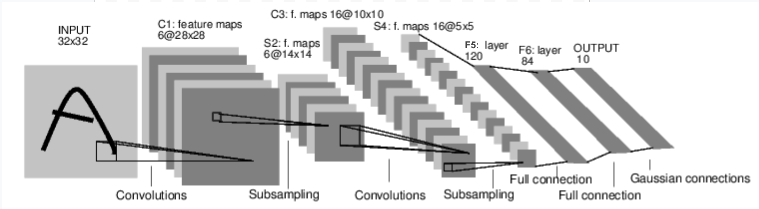

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        # カーネル(重み)を定義
        
        # 入力CH数=1, 出力CH数=6となる3x3の畳み込み層を定義
        self.conv1 = nn.Conv2d(1, 6, 3)
        
        # 入力CH数=6, 出力CH数=となる3x3の畳み込み層を定義
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        # 全結合層の定義: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6x6 from image dim
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        """順伝播処理を定義
        """
        
        # 3層目: ReLU & Maxpooling(2x2)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 4層目: ReLU & Maxpooling(2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # 入力行列を平坦化
        x = x.view(-1, self.num_flat_features(x))
        
        # 5層目: ReLU & 全結合層(No.1)
        x = F.relu(self.fc1(x))
        
        # 6層目: ReLU & 全結合層(No.2)
        x = F.relu(self.fc2(x))
        
        # 7層目: 全結合層(No.3)
        x = self.fc3(x)
        
        # 出力はロジット?
        return x
    
    def num_flat_features(self, x):
        """入力行列を平坦化
        """
        
        # バッチ次元(0次元目)の入力行列のサイズを取得
        size = x.size()[1:]
        num_features = 1
        for s in size:
            # 各次元の要素数の総乗を取る
            num_features *= s
        return num_features

In [4]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- **モデルの学習パラメータは`net.parameters()`で取得できる**

In [5]:
# 定義したモデルの学習パラメータを取得する
params = list(net.parameters())

print(params)
print(len(params))
# 0層目のパラメータ数
print(params[0].size())  # 6ch分の3*3行列

[Parameter containing:
tensor([[[[ 0.2333, -0.1910, -0.1037],
          [ 0.0045, -0.0727, -0.2804],
          [-0.3333, -0.1769, -0.2653]]],


        [[[ 0.0447,  0.1095,  0.1160],
          [ 0.2099, -0.2268, -0.0883],
          [ 0.0395,  0.0928, -0.1334]]],


        [[[ 0.1540, -0.0755,  0.2902],
          [ 0.0509, -0.1548,  0.0550],
          [-0.1836, -0.1346, -0.0693]]],


        [[[ 0.2435,  0.1537, -0.3231],
          [ 0.2374, -0.1809,  0.0887],
          [ 0.0429,  0.0961, -0.0188]]],


        [[[ 0.2727, -0.1689,  0.2836],
          [-0.2324,  0.2550, -0.0799],
          [ 0.1234,  0.0473, -0.1832]]],


        [[[ 0.2382, -0.0944,  0.0125],
          [-0.1611, -0.1301, -0.1965],
          [-0.1812, -0.1530, -0.1324]]]], requires_grad=True), Parameter containing:
tensor([-0.1111, -0.1385,  0.2404,  0.1627, -0.0675,  0.1263],
       requires_grad=True), Parameter containing:
tensor([[[[ 8.4159e-02,  1.1533e-01,  3.7639e-02],
          [ 8.4062e-02, -1.1606e-01,  1.1915e

In [6]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0126,  0.0124,  0.0946,  0.0958,  0.0334, -0.0369, -0.0430, -0.0028,
         -0.0632, -0.0591]], grad_fn=<AddmmBackward>)


## 振り返り

- `torch.Tensor()``: autograd(自動微分)操作をサポートした多次元配列クラス
  - 特定のテンソルに関連した勾配を保持できる
  
- `nn.Module`: ネットワークの重みパラメータをカプセル化する便利な方法. 
  - パラメータをGPUに移動させたり, 外部に保存したり, ロードするためのヘルパー関数を持つ
  
- `nn.Parameter`: テンソルの一種で, モジュールの属性変数として割り当てられる

- `autograd.Function`: autograd(自動微分)操作の順伝播および逆伝播の定義を実装する
  - すべてのテンソル操作は, その操作で生成したTensorに対応するFunctionを関連付けることで, そのテンソルに対する計算履歴を保持している

# 損失関数

- 損失関数は, **モデルの出力**と**ターゲットラベル**のペアを入力として, NNの出力が目標からどのくらい乖離しているかを推定する値を計算する
- nnパッケージには様々な損失関数が用意されている
  - https://pytorch.org/docs/nn.html#loss-functions

In [9]:
output = net(input)
target = torch.randn(10)     # 適当な正解targetを用意
target = target.view(1, -1)  # targetの形をoutputに合わせる
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3233, grad_fn=<MseLossBackward>)


In [19]:
i = loss.grad_fn
while i:
    print(str(i))
    if hasattr(i, 'next_functions'):
        i = i.next_functions

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

# 誤差逆伝播

- 損失の誤差逆伝播は`loss.backward()`を実行する
- 蓄積させないために, 既存の勾配を`net.zero_grad()`で取り除いておく

In [2]:
net.zero_grad()  # netパラメータの勾配をゼロ初期化

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

# 損失に対する誤差逆伝播を実行
loss.backward()

print('conv1.bias.grad after backward')
print(net1.conv1.bias.grad)

NameError: name 'net' is not defined

# 重みの更新